# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2023/24
 * Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
 * Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal, Paul Wollenhaupt
 * Due date: **Tuesday, Nov 21, before 10:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 3-4. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution to the marked cells.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

#### **TODO**
Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.

Hint: Use the package `gdown` to download files from google drive.

```python
!conda install -y gdown
!gdown <file_id>
```

Here's how to find the `file_id`: 
If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [2]:
# TODO Download setup!conda install -y gdown
!conda install -y gdown

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-4.7.1                |     pyhd8ed1ab_0          19 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          34 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1ab_0

In [3]:
# TODO import setup.py
import gdown
!gdown --id 1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk
From (redirected): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk&confirm=t&uuid=61252c1f-abb5-476e-ac4d-ed42ebe9962b
To: /kaggle/working/setup.py
100%|██████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 43.1MB/s]


## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [4]:
# TODO define device
from setup import *
device = get_device() 
device

device(type='cuda', index=0)

In [5]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split and initialize data loaders

trainset, testset = grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size)

100%|██████████| 170498071/170498071 [00:04<00:00, 34929324.57it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [6]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

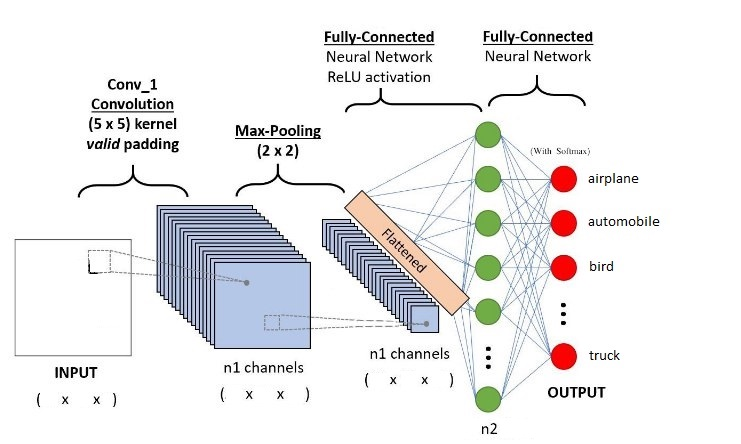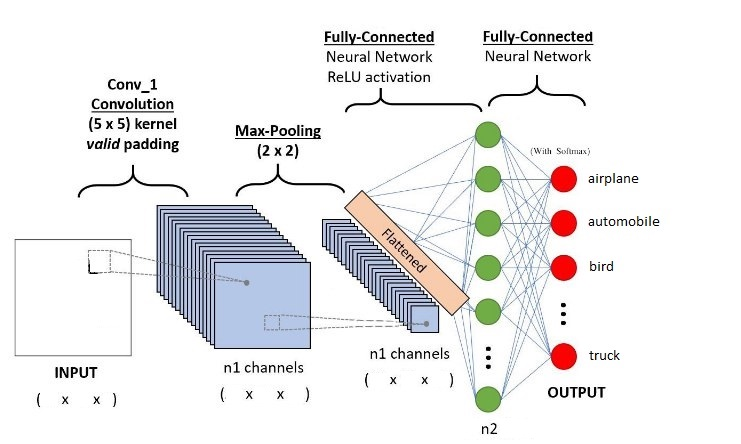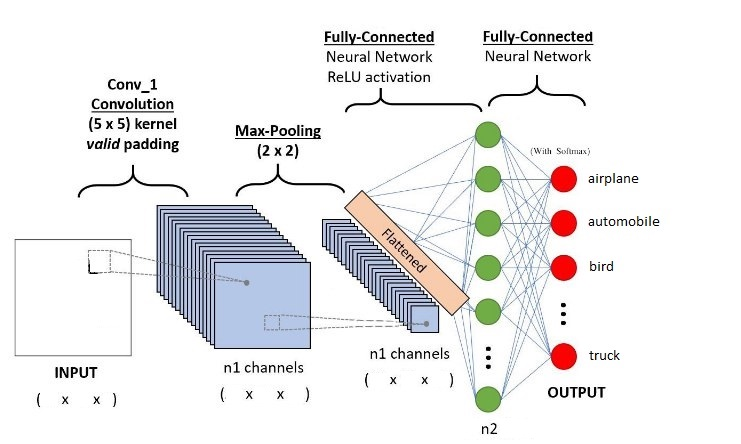

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
- What is the number of parameters for conv_1?

**Your answers here**

- 32x32x3
- 28x28x32
- 14x14x32


In [ ]:
# TODO define model

class CNN(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(CNN, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding = 'valid'),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),  
        )
        
        self.classifier = nn.Sequential(
        nn.Linear(14*14*32,512),
        nn.ReLU(),
        nn.Linear(512,10)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x


#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

In [ ]:
# TODO train and plot
model_CNN = CNN(10)
model_CNN.to(device)

lr = 0.001
optimizer = torch.optim.Adam(model_CNN.parameters(), lr)
num_epochs = 10

In [ ]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_CNN, optimizer, 
                loss_function, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)


In [ ]:
plot('CNN_results', 'Loss', train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('CNN_results', 'Accuracy', train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**

**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

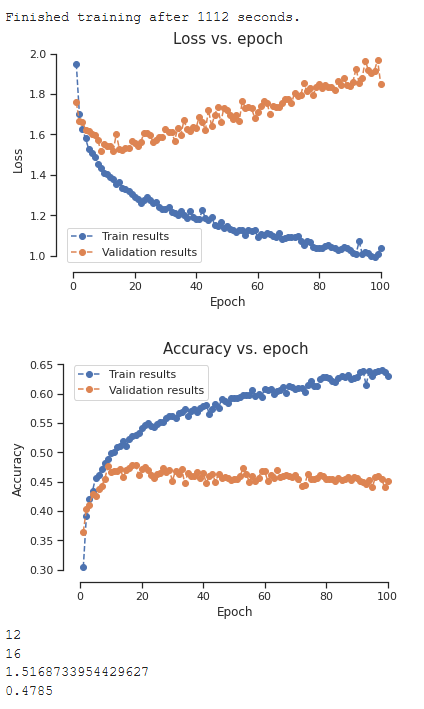

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [ ]:
# TODO train and plot
model_CNN_60 = CNN(10)
model_CNN_60.to(device)
optimizer = torch.optim.Adam(model_CNN_60.parameters(), lr)
num_epochs = 60


train_losses_60, val_losses_60, train_accs_60, val_accs_60, confusion_matrix_60 = run_training(model_CNN_60, optimizer, 
                loss_function, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

In [ ]:
plot('CNN results with 60 epochs', 'Loss', train_losses_60, val_losses_60, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

plot('CNN results with 60 epochs', 'Accuracy', train_accs_60, val_accs_60, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**
-Only one convulutional layer, not really suited to detct structures in images. Massively overfitting as can be seen by the validation results.

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture using the following information:



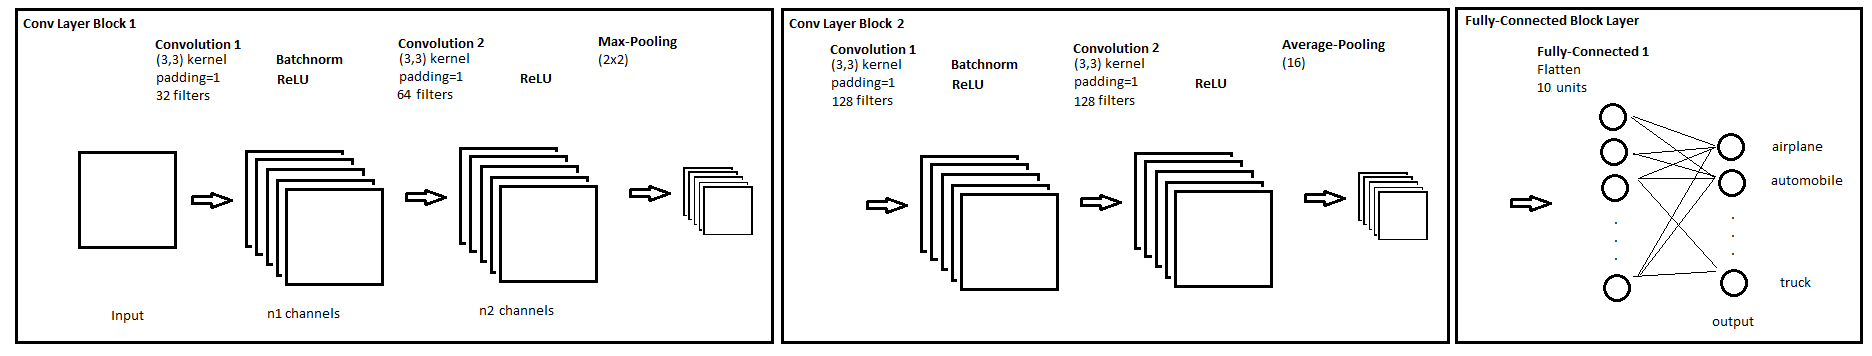

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

In [ ]:
#TODO define model 2

class CNN_2(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(CNN_2, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 16),
            )
        
        self.classifier = nn.Sequential(
            nn.Linear(128,10) # pooling size 16x16 so 2 per feature map why not 256?
            )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

#### **TODO** 

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot
model_CNN2 = CNN_2(10)
model_CNN2.to(device)

lr = 0.1
optimizer = torch.optim.Adam(model_CNN2.parameters(), lr)
num_epochs = 30



In [ ]:
train_losses_2, val_losses_2, train_accs_2, val_accs_2, confusion_matrix_2 = run_training(model_CNN2, optimizer, 
                loss_function, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

In [ ]:
plot('CNN2 results', 'Loss', train_losses_2, val_losses_2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('CNN2 results', 'Accuracy', train_accs_2, val_accs_2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

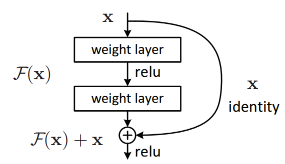

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

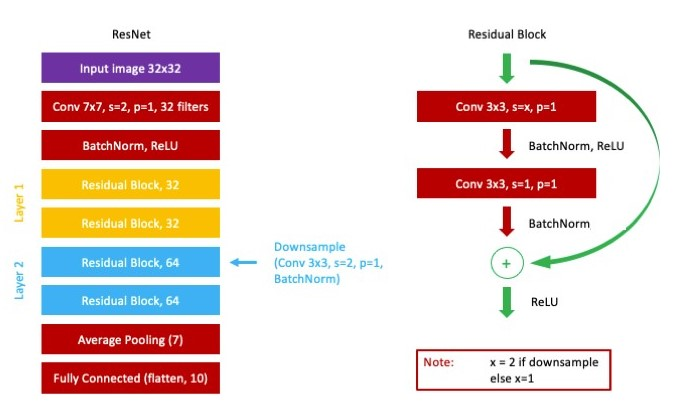

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [7]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
        def __init__(self, downsample, in_channels, out_channels, stride):
            super(ResidualBlock, self).__init__()
            
         

                       
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding = 1)
            self.bn1= nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding = 1)
            self.bn2= nn.BatchNorm2d(out_channels)
            
            self.for_downsampling = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1,  stride = stride)
            
            self.downsample = downsample

        
        def forward(self, x):
               
            
            identity = x
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            if self.downsample:
                identity = self.for_downsampling(identity)
                
            x += identity
            x = self.relu(x)
            
            return x
            
        

            

In [8]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
    def __init__(self, block):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.layer0 = self._make_layer(block, downsample=False)
        self.layer1 = self._make_layer(block, downsample = True)
        self.avgpool = nn.AvgPool2d(kernel_size = 7)
        self.Linear = nn.Linear(64,10)
        
        
    def _make_layer(self,block,downsample):
        
        layers=[]
        
        if downsample:
            layers.append(block(downsample, in_channels = 32, out_channels = 64 , stride = 2))
            layers.append(block(downsample, in_channels = 64, out_channels= 64, stride = 1))

                
        else:
            layers.append(block(downsample, in_channels = 32, out_channels= 32, stride = 1))
            layers.append(block(downsample, in_channels = 32, out_channels= 32, stride = 1))
        
        return nn.Sequential(*layers)
            
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        
        x= torch.flatten(x,1)
        
        x= self.Linear(x)
        
        return x
        
    
        
        

In [30]:
# TODO train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.
model_res = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_res.parameters(), lr)
num_epochs = 60


train_losses_res, val_losses_res, train_accs_res, val_accs_res, confusion_matrix_res = run_training(model_res, optimizer, 
                loss_function, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

Finished training after 754 seconds.


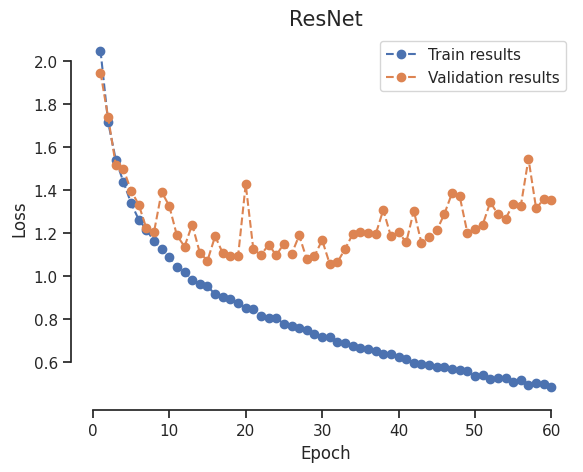

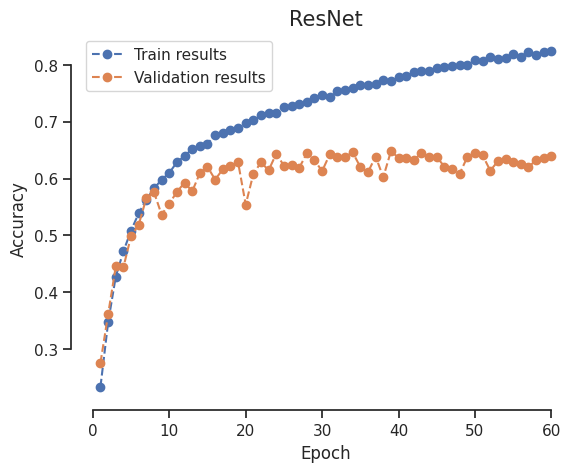

In [31]:
plot('ResNet', 'Loss', train_losses_res, val_losses_res, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('ResNet', 'Accuracy', train_accs_res, val_accs_res, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

In [13]:
# TODO Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.
class Block(nn.Module):
        def __init__(self, downsample, in_channels, out_channels, stride):
            super(Block, self).__init__()
            
         

                       
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding = 1)
            self.bn1= nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding = 1)
            self.bn2= nn.BatchNorm2d(out_channels)
            

        
        def forward(self, x):
               
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            
            return x
            
        

In [32]:
model_net = ResNet(Block).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_net.parameters(), lr)
num_epochs = 60


train_losses_net, val_losses_net, train_accs_net, val_accs_net, confusion_matrix_net = run_training(model_net, optimizer, 
                loss_function, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

Finished training after 748 seconds.


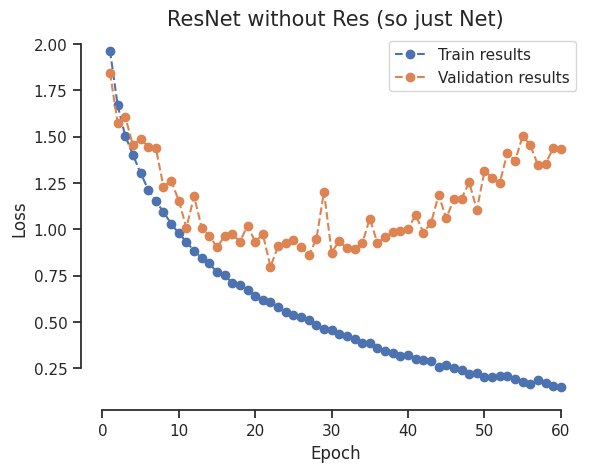

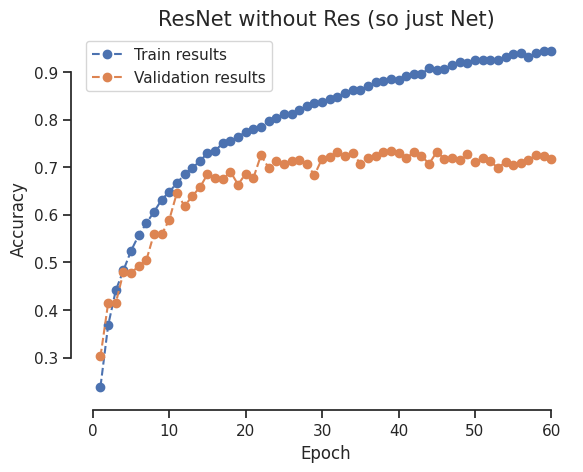

In [33]:
plot('ResNet without Res (so just Net)', 'Loss', train_losses_net, val_losses_net, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('ResNet without Res (so just Net)', 'Accuracy', train_accs_net, val_accs_net, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
- In deeper networks, how would you expect residual blocks to influence training time? why?
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [21]:
# TODO change run_training (you can copy the code from setup.py here and create a new method here 
# or just change/create a new method it in the python file)
def run_training_ws(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, scheduler, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        
        scheduler.step()
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix





In [23]:
# TODO train and plot with step size 1, gamma 0.1
import torch.optim.lr_scheduler as lr_scheduler

model_s1 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s1.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
num_epochs = 10


train_losses_scheduler1, val_losses_scheduler1, train_accs_scheduler1, val_accs_scheduler1, confusion_matrix_scheduler1 = run_training_ws(model_s1, 
                                optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)

Finished training after 128 seconds.


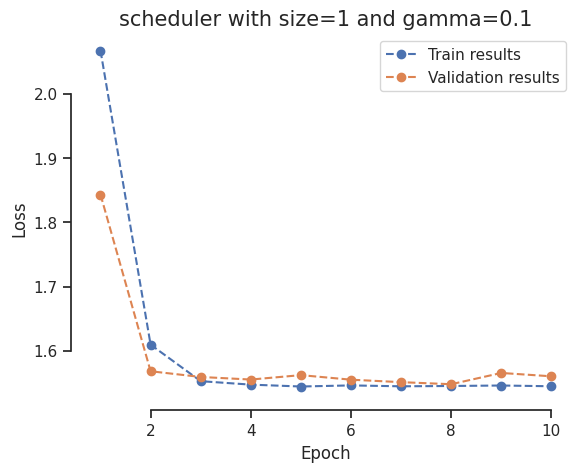

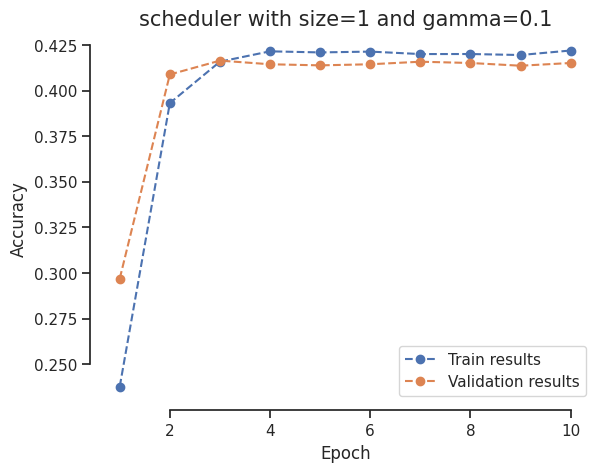

In [25]:
plot('scheduler with size=1 and gamma=0.1', 'Loss', train_losses_scheduler1, val_losses_scheduler1, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('scheduler with size=1 and gamma=0.1', 'Accuracy', train_accs_scheduler1, val_accs_scheduler1, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

In [26]:
# TODO train and plot with step size 1, gamma 0.9

model_s2 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s2.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)
num_epochs = 10


train_losses_scheduler2, val_losses_scheduler2, train_accs_scheduler2, val_accs_scheduler2, confusion_matrix_scheduler2 = run_training_ws(model_s2, 
                                optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)

Finished training after 128 seconds.


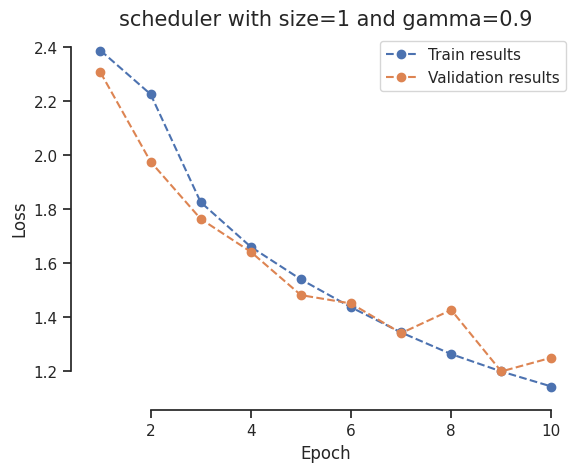

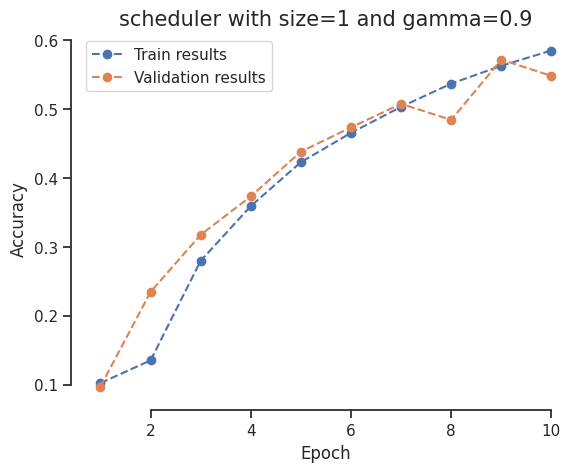

In [27]:
plot('scheduler with size=1 and gamma=0.9', 'Loss', train_losses_scheduler2, val_losses_scheduler2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('scheduler with size=1 and gamma=0.9', 'Accuracy', train_accs_scheduler2, val_accs_scheduler2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [28]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

model_s3 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s3.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
num_epochs = 30


train_losses_scheduler3, val_losses_scheduler3, train_accs_scheduler3, val_accs_scheduler3, confusion_matrix_scheduler3 = run_training_ws(model_s3, 
                                optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)


Finished training after 381 seconds.


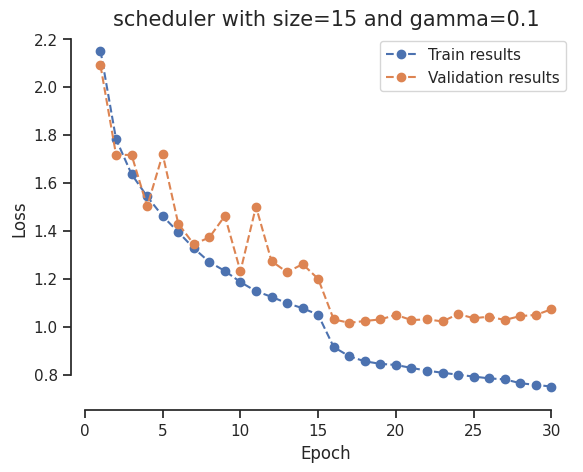

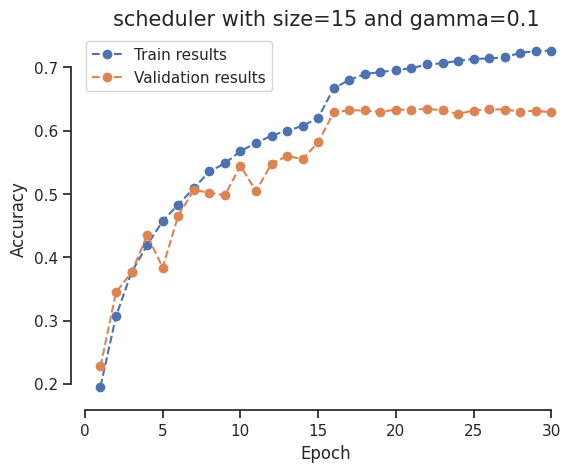

In [29]:
plot('scheduler with size=15 and gamma=0.1', 'Loss', train_losses_scheduler3, val_losses_scheduler3, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('scheduler with size=15 and gamma=0.1', 'Accuracy', train_accs_scheduler3, val_accs_scheduler3, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

In [ ]:
# TODO train and plot with different schedulers

**Your answers here**